In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sb
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import precision_score, recall_score, classification_report

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [2]:
plt.style.set = "ggplot2"

In [3]:
dataset = pd.read_csv("/kaggle/input/winemag-data-130k-v2-csv/winemag-data-130k-v2.csv")

In [4]:
dataset.loc[0,"description"]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [5]:
dataset.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


<Axes: >

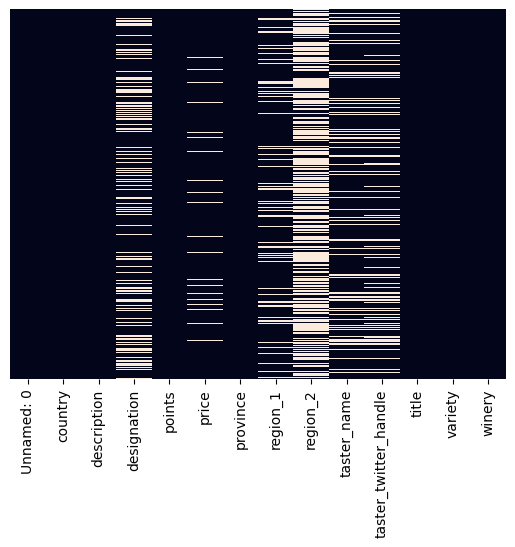

In [6]:
sb.heatmap(dataset.isnull(), yticklabels=False, cbar=False)

See that a lot of missing values in dataset

<p> Replace designation with Unknown

In [7]:
dataset['designation'] = dataset['designation'].fillna('Unknown')

<p> Drop columns that have no sense in my dataset

In [8]:
wine = dataset.drop(['Unnamed: 0','region_1','region_2','taster_twitter_handle'], axis=1)
wine.head()

,country,description,designation,points,price,province,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


<Axes: >

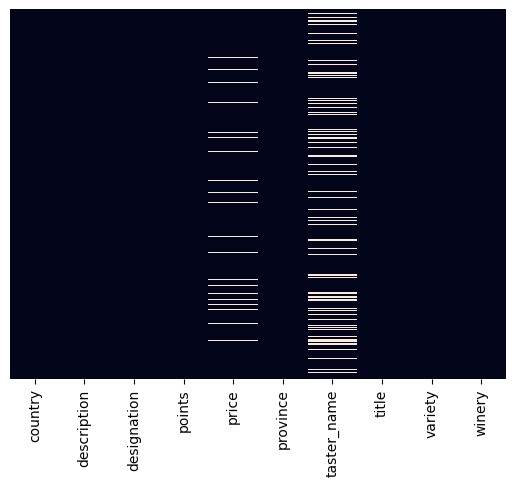

In [9]:
sb.heatmap(wine.isnull(),yticklabels=False,cbar=False)

In [10]:
Q1 = wine['price'].quantile(0.25)
Q3 = wine['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

wine_filtered = wine[(wine['price'] >= lower_bound) & (wine['price'] <= upper_bound)]

print(f"Original dataset size: {wine.shape[0]}")
print(f"Filtered dataset size: {wine_filtered.shape[0]} (outliers removed: {wine.shape[0] - wine_filtered.shape[0]})")

Original dataset size: 129971
Filtered dataset size: 113734 (outliers removed: 16237)


<Axes: >

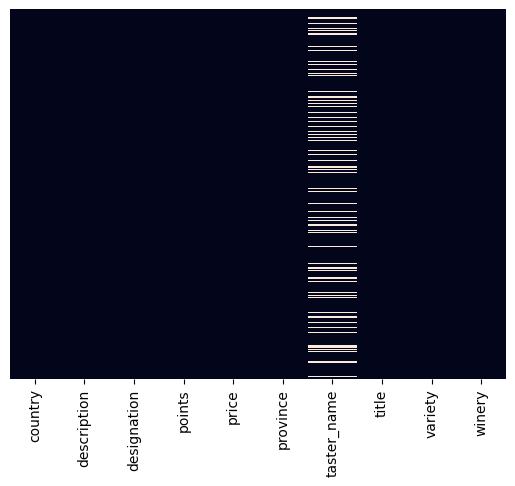

In [11]:
sb.heatmap(wine_filtered.isnull(), yticklabels=False,cbar=False)

<p> Replace taster name with Unknown

<Axes: >

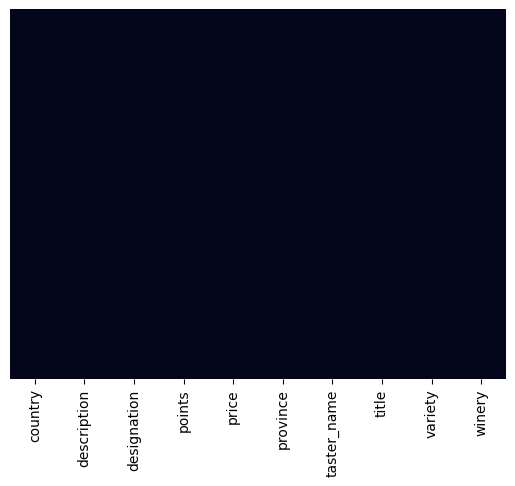

In [12]:
wine_filtered["taster_name"] = wine_filtered['taster_name'].fillna("Unknown")
sb.heatmap(wine_filtered.isnull(), yticklabels=False,cbar=False)

In [13]:
unique_wine = wine_filtered
unique_wine = unique_wine.reset_index(drop=True)
print(len(unique_wine))
unique_wine_desc = unique_wine
unique_wine = unique_wine.drop("description", axis=1)
unique_wine.head()

113734


,country,designation,points,price,province,taster_name,title,variety,winery
0,Portugal,Avidagos,87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,US,Unknown,87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,US,Reserve Late Harvest,87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,Spain,Ars In Vitro,87,15.0,Northern Spain,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [14]:
len(unique_wine)

113734

In [15]:
len(unique_wine_desc)

113734

Decided to use bag of words for description because its clear that score depends on composition of wine

In [16]:
corpus = []
for i in range(0, len(unique_wine)):
    description = re.sub('[^a-zA-Z]', ' ', unique_wine_desc['description'][i])
    description = description.lower().split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    description = [ps.stem(word) for word in description if not word in set(all_stopwords)]
    description = ' '.join(description)
    corpus.append(description)

Used stemmer to have words in initial form and deleted words that have no sense

In [17]:
unique_words = set()
for text in corpus:
    unique_words.update(text.split())
length = len(unique_words)
print(f"Number of unique words: {length}")

Number of unique words: 20283


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000)
words_array = cv.fit_transform(corpus).toarray()
words_df = pd.DataFrame(words_array)
X = pd.concat([words_df.reset_index(drop=True), unique_wine.reset_index(drop=True)], axis=1)
Y = unique_wine["points"]
X = X.drop("points", axis=1)

In [19]:
Y.shape

(113734,)

In [20]:
X.shape

(113734, 5008)

<Axes: >

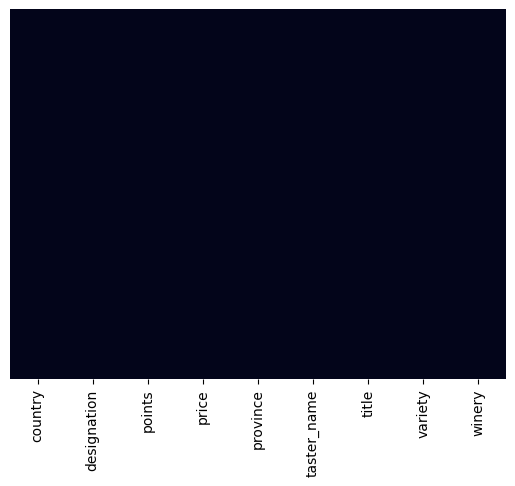

In [21]:
sb.heatmap(unique_wine.isnull(), yticklabels=False, cbar=False)

In [22]:
missing_values = X.isnull().sum()
for col, num in missing_values.items():
    if num > 0:
        print(f"{col}: {num} missing values")

country: 59 missing values
province: 59 missing values
variety: 1 missing values


In [23]:
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4998,4999,country,designation,price,province,taster_name,title,variety,winery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,Portugal,Avidagos,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,0,0,0,0,0,0,0,0,0,0,...,0,0,US,Unknown,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,0,0,0,0,0,0,0,0,0,0,...,0,0,US,Reserve Late Harvest,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,0,0,0,0,0,0,0,0,0,0,...,0,0,US,Vintner's Reserve Wild Child Block,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,0,0,0,0,0,0,0,0,0,0,...,0,0,Spain,Ars In Vitro,15.0,Northern Spain,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [24]:
X_new = X.drop(["winery", "designation", "title"], axis=1)

In [25]:
X_new.columns = pd.DataFrame(X_new).columns.astype(str)

In [26]:
X.shape

(113734, 5008)

In [27]:
Y.shape

(113734,)

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ["country", "province", "taster_name", "variety"])], remainder='passthrough')
X_new = np.array(ct.fit_transform(X_new))

In [29]:
X["winery"].value_counts()

winery
Testarossa               211
DFJ Vinhos               209
Wines & Winemakers       209
Chateau Ste. Michelle    193
Williams Selyem          189
                        ... 
Margalit                   1
Spin the Bottle            1
Ribera de Ulver            1
Cruz                       1
Penedo Borges              1
Name: count, Length: 15544, dtype: int64

In [30]:
frequency = X['winery'].value_counts(normalize=True)
X['winery_encoded'] = X['winery'].map(frequency)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4999,country,designation,price,province,taster_name,title,variety,winery,winery_encoded
0,0,0,0,0,0,0,0,0,0,0,...,0,Portugal,Avidagos,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0.000070
1,0,0,0,0,0,0,0,0,0,0,...,0,US,Unknown,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0.000123
2,0,0,0,0,0,0,0,0,0,0,...,0,US,Reserve Late Harvest,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0.000088
3,0,0,0,0,0,0,0,0,0,0,...,0,US,Vintner's Reserve Wild Child Block,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0.000158
4,0,0,0,0,0,0,0,0,0,0,...,0,Spain,Ars In Vitro,15.0,Northern Spain,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,0.000141


In [31]:
X_new

array([[ 0.,  0.,  0., ...,  0.,  0., 15.],
       [ 0.,  0.,  0., ...,  0.,  0., 14.],
       [ 0.,  0.,  0., ...,  0.,  0., 13.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0.,  0.,  0., ...,  0.,  0., 32.],
       [ 0.,  0.,  0., ...,  0.,  0., 21.]])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.25, random_state=1)

In [33]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
y_hat = regressor.predict(X_test)
y_hat

array([86.50849 , 87.04307 , 89.138565, ..., 84.55076 , 87.56056 ,
       85.13372 ], dtype=float32)

In [35]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("r2: ", r2_score(y_train,regressor.predict(X_train)), "rmse: ", mean_squared_error(y_train, regressor.predict(X_train)))
print("r2: ", r2_score(y_test, y_hat), "rmse: ", mean_squared_error(y_test, regressor.predict(X_test)))
                                                                                             

r2:  0.7498554139433027 rmse:  2.11865885074028
r2:  0.7002153377661073 rmse:  2.5032194980531313


In [36]:
print(y_test.head())
print(pd.DataFrame(y_hat))

56561    87
76159    86
87659    90
41441    89
66291    84
Name: points, dtype: int64
               0
0      86.508492
1      87.043068
2      89.138565
3      90.673561
4      87.130424
...          ...
28429  88.238708
28430  87.181099
28431  84.550758
28432  87.560562
28433  85.133720

[28434 rows x 1 columns]


In [46]:
df = pd.concat([y_test.reset_index(), pd.DataFrame(y_hat, columns=['Predicted'])], axis=1, ignore_index=True)
df = df.drop([0], axis=1)
df.columns = ["True", "Predicted"]
df.head()

,True,Predicted
0,87,86.508492
1,86,87.043068
2,90,89.138565
3,89,90.673561
4,84,87.130424


In [38]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.7, 0.85],
    'colsample_bytree': [0.7, 0.85, 1.0],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Використання TQDMGridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=5,
    n_jobs=1,
)

# Запуск тренування
grid_search.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("r2: ", r2_score(y_train,grid_search.predict(X_train)), "rmse: ", mean_squared_error(y_train, grid_search.predict(X_train)))
print("r2: ", r2_score(y_test, grid_search.predict(X_test)), "rmse: ", mean_squared_error(y_test, grid_search.predict(X_test)))
grid_search.best_params_

Decided to try classifier trying to predict category (range 80-85 etc.)

In [39]:
def transform_column(data):
    if data <= 85:
        return 0
    elif data <= 90:
        return 1
    elif data <= 95:
        return 2
    else:
        return 3


Y_train_class = pd.DataFrame([])
Y_train_class["value"] = y_train.iloc[:]
Y_train_class["category"] = y_train.apply(lambda x: transform_column(x))

Y_test_class = pd.DataFrame([])
Y_test_class["value"] = y_test.iloc[:]
Y_test_class["category"] = y_test.apply(lambda x: transform_column(x))

In [40]:
from xgboost import XGBClassifier
classifier = XGBClassifier(
    params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.2,
    'max_depth': 5,
    'n_estimators': 150,
    'subsample': 0.7
})
classifier.fit(X_train, Y_train_class["category"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
# Обчислення Accuracy
print("Accuracy: ", classifier.score(X_train, Y_train_class["category"]))

# Перевірка форми міток
print("Shape of Y_train_class['category']: ", Y_train_class["category"].shape)

# Перевіряємо, чи це багатовихідна класифікація
if len(Y_train_class["category"].shape) > 1 and Y_train_class["category"].shape[1] > 1:
    # Якщо є кілька виходів, обчислюємо classification_report для кожного
    predictions = classifier.predict(X_train)
    for i in range(Y_train_class["category"].shape[1]):
        print(f"Report for output {i}:")
        print(classification_report(Y_train_class["category"][:, i], predictions[:, i]))
else:
    # Звичайна мультикласова класифікація
    predictions = classifier.predict(X_train)
    print("Classification Report:")
    print(classification_report(Y_train_class["category"], predictions))

Accuracy:  0.8153927315357562
Shape of Y_train_class['category']:  (85300,)
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     15590
           1       0.80      0.92      0.86     50505
           2       0.85      0.69      0.76     19028
           3       1.00      0.88      0.94       177

    accuracy                           0.82     85300
   macro avg       0.88      0.78      0.82     85300
weighted avg       0.82      0.82      0.81     85300



In [42]:
Y_test_class["category"].isnull().value_counts()
Y_test_class.head(5)

,value,category
56561,87,1
76159,86,1
87659,90,1
41441,89,1
66291,84,0


In [43]:
# Обчислення Accuracy
print("Accuracy: ", classifier.score(X_test, Y_test_class["category"]))

# Перевірка форми міток
print("Shape of Y_test_class['category']: ", Y_test_class["category"].shape)

# Перевіряємо, чи це багатовихідна класифікація
if len(Y_test_class["category"].shape) > 1 and Y_test_class["category"].shape[1] > 1:
    # Якщо є кілька виходів, обчислюємо classification_report для кожного
    predictions = classifier.predict(X_train)
    for i in range(Y_test_class["category"].shape[1]):
        print(f"Report for output {i}:")
        print(classification_report(Y_test_class["category"][:, i], predictions[:, i]))
else:
    # Звичайна мультикласова класифікація
    predictions = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(Y_test_class["category"], predictions))

Accuracy:  0.7683758880213829
Shape of Y_test_class['category']:  (28434,)
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.56      0.65      5046
           1       0.77      0.89      0.82     17048
           2       0.76      0.62      0.68      6280
           3       0.00      0.00      0.00        60

    accuracy                           0.77     28434
   macro avg       0.58      0.52      0.54     28434
weighted avg       0.77      0.77      0.76     28434



<h3>As final model I chosed XGBoostRegressor because it predicts a number and accuracy is not much worse than when I used classification

<H3> XAI (SHAP)

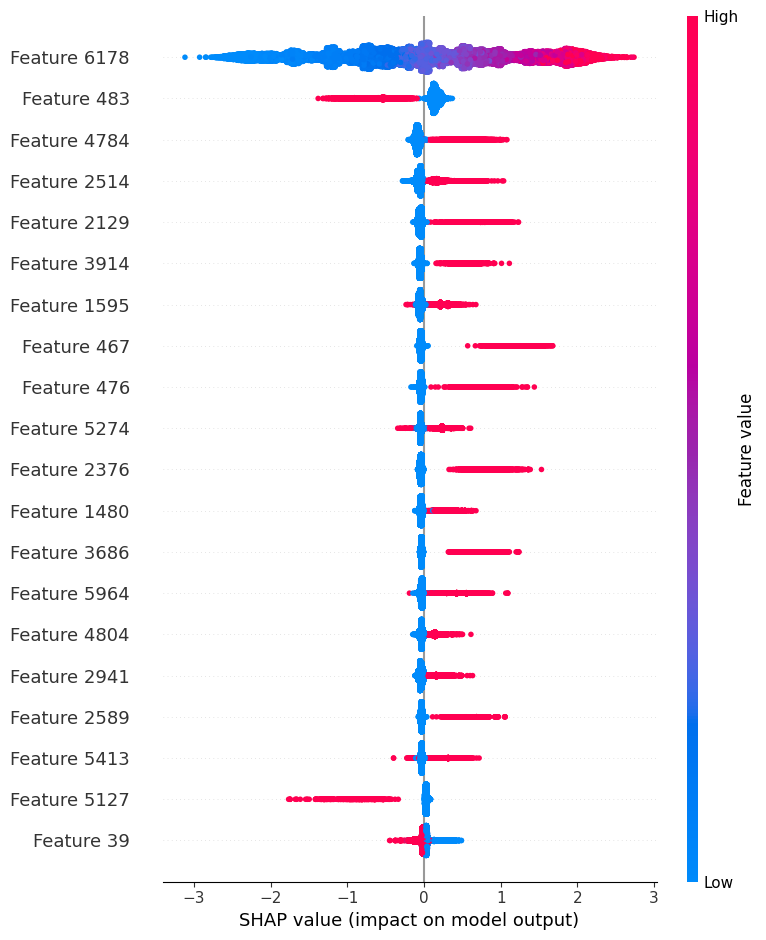

In [44]:
import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

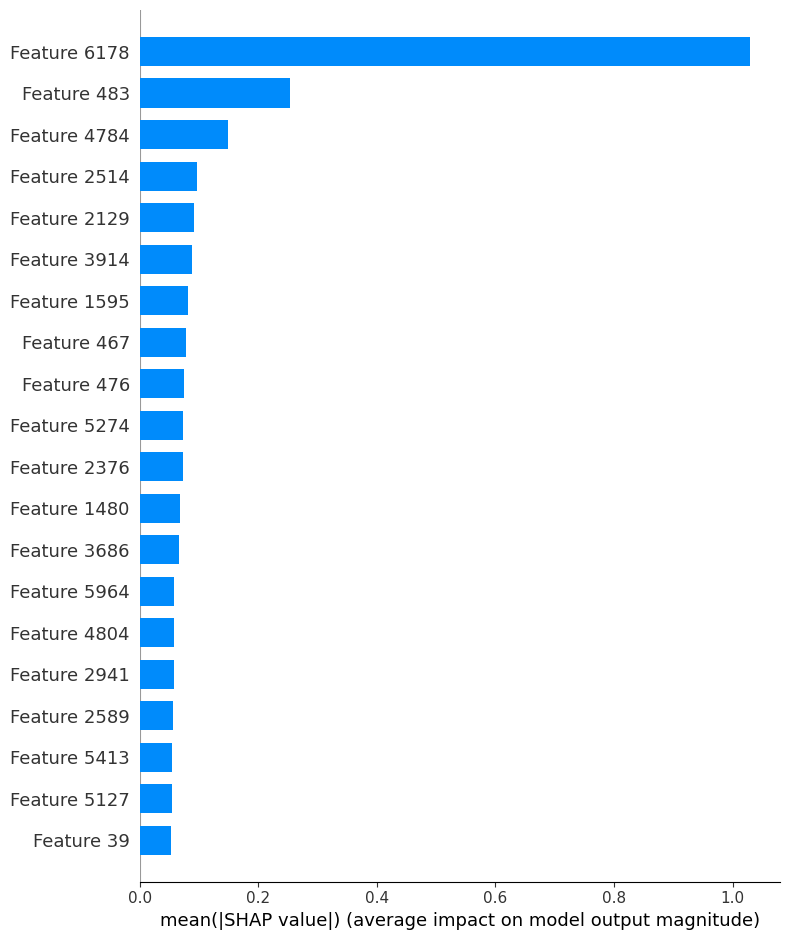

In [45]:
shap.summary_plot(shap_values, X_test, plot_type="bar")